In [2]:
import spateo as st
import anndata
import plotly.express as px
import plotly.io as pio
import numpy as np
pio.renderers.default = 'iframe'

2024-07-25 10:03:00.622445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 10:03:00.914443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 10:03:26.043720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/jdfsbjcas1/ST_BJ/P21H28400N0232/guojingwen/software/miniconda3/envs/py38_spateo/lib/python3.8/site-packages/spaghetti/network.py:40: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users c

In [58]:
import os

od = '8.41_borderline' #P13
if not os.path.exists(od):
    os.mkdir(od)
os.chdir(od)

In [ ]:
adata_path = 'raw_annotated.h5ad'
adata = anndata.read(adata_path)

In [60]:
adata.obsm['bin20_spatial'] = adata.obsm['spatial']//20
adata.uns["__type"] = "UMI"
adata_tmp = adata.copy()
adata_tmp.obs["tmp_borderline"] = 0
cluster_key="annotated_cluster"
source_clusters=['DCIS cells']
adata_tmp.obs["tmp_borderline"][adata_tmp.obs[cluster_key].isin(source_clusters)] = 1

/tmp/ipykernel_3276/3702402328.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
from collections import Counter
Counter(adata_tmp.obs["tmp_borderline"])

Counter({0: 217615, 1: 35040})

In [ ]:
spatial_key="bin20_spatial"
bin_size=1
boundary_img = st.digitization.contour.gen_cluster_image(adata_tmp, bin_size, spatial_key, "tmp_borderline", show=True)

8 30


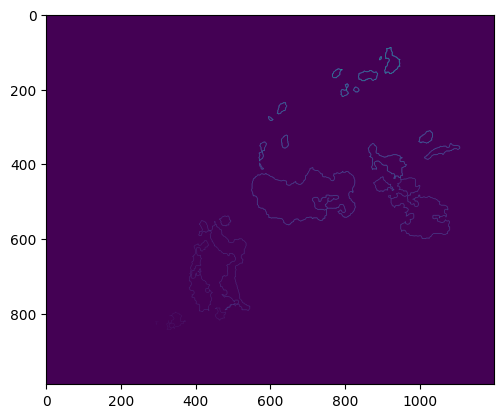

In [62]:
import cv2
from typing import Any, List, Optional, Tuple, Union
from skimage import morphology
import matplotlib.pyplot as plt

source_label = np.unique(adata_tmp[np.isin(adata_tmp.obs["tmp_borderline"],[1,],),:,].obs["cluster_img_label"])
k_size = 8
min_area = 30
k_size = int(k_size * bin_size)
min_area = int(min_area * bin_size * bin_size)
print(k_size, min_area)
cluster_labels = source_label

cluster_label_image = boundary_img
cluster_labels = source_label
cluster_image_close = cluster_label_image.copy()
if type(cluster_labels) == int:
    cluster_image_close = np.where(cluster_image_close == cluster_labels, cluster_image_close, 0)
else:
    cluster_image_close = np.where(np.isin(cluster_image_close, cluster_labels), cluster_image_close, 0)
close_kernel = cv2.MORPH_ELLIPSE
kernal = cv2.getStructuringElement(close_kernel, (k_size, k_size))
cluster_image_close = cv2.morphologyEx(cluster_image_close, cv2.MORPH_CLOSE, kernal)

cluster_image_close = morphology.remove_small_objects(
    cluster_image_close.astype(bool),
    min_area,
    connectivity=2,
).astype(np.uint8)

contours, _ = cv2.findContours(cluster_image_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cluster_image_contour = np.zeros((cluster_label_image.shape[0], cluster_label_image.shape[1]))
for i in range(len(contours)):
    cv2.drawContours(cluster_image_contour, contours, i, i + 1, bin_size)

plt.imshow(cluster_image_contour)

In [ ]:
plt.imshow(cluster_image_contour).figure.savefig('cluster_image_contour.tif', dpi=300, bbox_inches='tight')

In [49]:
len(contours)

4

In [8]:
##单独拿出一个contour进行扩圈，封装成函数
def extend_contour_i(k_contour):
    borderline_list = [tuple(i[0]) for i in contours[k_contour]]
    borderline_list.append(borderline_list[0])
    borderline_img = cluster_image_contour
    extend_width = 25

    extend_layer_mask = np.zeros_like(borderline_img, dtype=np.uint8)
    for pt in borderline_list:
        cv2.circle(extend_layer_mask, pt, extend_width, 255, -1)

    extend_layer_img = np.zeros_like(borderline_img, dtype=np.uint8)
    extend_layer_contour, hierarchy = cv2.findContours(extend_layer_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(extend_layer_img, extend_layer_contour, -1, 255, 1)
    ext_contour_i = [i for i in range(len(hierarchy[0])) if hierarchy[0][i][-1]==-1][0]
    ext_contour = extend_layer_contour[ext_contour_i]
    int_contours = [sub for i, sub in enumerate(extend_layer_contour) if i != ext_contour_i]

    all_layer_img = np.zeros_like(borderline_img, dtype=np.uint8)
    #cv2.drawContours(all_layer_img, [contours[21]], -1, 255, 1)
    cv2.drawContours(all_layer_img, [*extend_layer_contour, contours[k_contour]], -1, 255, 1)
    return(all_layer_img)

In [ ]:
plt.imshow(extend_contour_i(0))

In [63]:
all_layer_img_floodfill_list = []
h, w = extend_contour_i(0).shape[:2]
all_layer_img_mask = np.zeros((h+2, w+2), np.uint8)
ext_color = 255
int_color = 100

In [35]:
def get_all_layer_img_floodfill(k_contour):
    print(k_contour)
    all_layer_img = extend_contour_i(k_contour)
    all_layer_img_floodfill = all_layer_img.copy()
    #print([Counter(all_layer_img_floodfill[i]) for i in range(all_layer_img_floodfill.shape[0])])
    borderline_list = [tuple(i[0]) for i in contours[k_contour]]
    borderline_list.append(borderline_list[0])
    borderline_img = cluster_image_contour
    extend_width = 25

    extend_layer_mask = np.zeros_like(borderline_img, dtype=np.uint8)
    for pt in borderline_list:
        cv2.circle(extend_layer_mask, pt, extend_width, 255, -1)

    extend_layer_img = np.zeros_like(borderline_img, dtype=np.uint8)
    extend_layer_contour, hierarchy = cv2.findContours(extend_layer_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(extend_layer_img, extend_layer_contour, -1, 255, 1)
    ext_contour_i = [i for i in range(len(hierarchy[0])) if hierarchy[0][i][-1]==-1][0]
    ext_contour = extend_layer_contour[ext_contour_i]
    int_contours = [sub for i, sub in enumerate(extend_layer_contour) if i != ext_contour_i]

    all_layer_img = np.zeros_like(borderline_img, dtype=np.uint8)
    cv2.drawContours(all_layer_img, [*extend_layer_contour, contours[k_contour]], -1, 255, 1)

    n_int_contours = len(int_contours)
    for i in range(all_layer_img_floodfill.shape[1]):
        for j in range(all_layer_img_floodfill.shape[0]):
            if ((cv2.pointPolygonTest(np.float32(ext_contour), tuple([i,j]), False)==1) & 
                (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([i,j]), False)==-1)):
                seedPoint=(i,j)
                #print(seedPoint)
                cv2.floodFill(all_layer_img_floodfill, all_layer_img_mask, seedPoint, ext_color)
            elif ((len(int_contours)>=1) & 
                  (sum([cv2.pointPolygonTest(np.float32(int_contour), tuple([i,j]), False) for int_contour in int_contours])==-n_int_contours) & 
                  (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([i,j]), False)==1)):
                seedPoint=(i,j)
                #print(seedPoint)
                cv2.floodFill(all_layer_img_floodfill, all_layer_img_mask, seedPoint, int_color)
            elif ((len(int_contours)==0) & 
                  (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([i,j]), False)==1)):
                seedPoint=(i,j)
                cv2.floodFill(all_layer_img_floodfill, all_layer_img_mask, seedPoint, int_color)

    cv2.drawContours(all_layer_img_floodfill, [*extend_layer_contour, contours[k_contour]], -1, 255, 1)
    return(all_layer_img_floodfill)

In [ ]:
from pytools import pmap
all_layer_img_floodfill_list2 = pmap(get_all_layer_img_floodfill, range(len(contours)), 5, if_return=True) #len(contours)

In [53]:
[i.shape for i in all_layer_img_floodfill_list2]

[(1202, 1238), (1202, 1238), (1202, 1238), (1202, 1238)]

In [65]:
all_layer_img_floodfill_stack = all_layer_img_floodfill_list2[0]
for all_layer_img_floodfill in all_layer_img_floodfill_list2[1:]:
    for i in range(all_layer_img_floodfill.shape[0]):
        for j in range(all_layer_img_floodfill.shape[1]):
            if all_layer_img_floodfill_stack[i,j]!=0:
                pass
            elif all_layer_img_floodfill_stack[i,j]==0 and all_layer_img_floodfill[i,j]!=0:
                all_layer_img_floodfill_stack[i,j] = all_layer_img_floodfill[i,j]

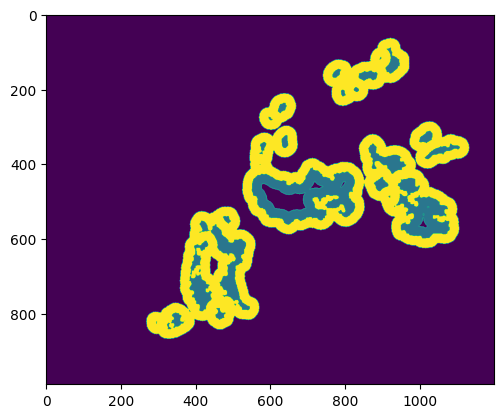

In [66]:
plt.imshow(all_layer_img_floodfill_stack)

In [19]:
def annotate_adata_bdl(k_contour):
    #print(k_contour)
    borderline_list = [tuple(i[0]) for i in contours[k_contour]]
    borderline_list.append(borderline_list[0])
    borderline_img = cluster_image_contour
    extend_width = 25

    extend_layer_mask = np.zeros_like(borderline_img, dtype=np.uint8)
    for pt in borderline_list:
        cv2.circle(extend_layer_mask, pt, extend_width, 255, -1)

    extend_layer_contour, hierarchy = cv2.findContours(extend_layer_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    ext_contour_i = [i for i in range(len(hierarchy[0])) if hierarchy[0][i][-1]==-1][0]
    ext_contour = extend_layer_contour[ext_contour_i]
    int_contours = [sub for i, sub in enumerate(extend_layer_contour) if i != ext_contour_i]

    n_int_contours = len(int_contours)
    bdl_dict_i = {}
    for i in range(adata_tmp.obs.shape[0]):
        idx_i = adata_tmp.obs.index[i]
        x20 = adata_tmp.obs.loc[idx_i]['x']//20
        y20 = adata_tmp.obs.loc[idx_i]['y']//20
        if ((cv2.pointPolygonTest(np.float32(ext_contour), tuple([y20,x20]), False)==1) & 
            (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([y20,x20]), False)==-1)):
            bdl_dict_i[idx_i] = 'external'
        elif ((len(int_contours)>=1) & 
                (sum([cv2.pointPolygonTest(np.float32(int_contour), tuple([y20,x20]), False) for int_contour in int_contours])==-n_int_contours) & 
                (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([y20,x20]), False)==1)):
            bdl_dict_i[idx_i] = 'internal'
        elif ((len(int_contours)==0) & 
                (cv2.pointPolygonTest(np.float32(contours[k_contour]), tuple([y20,x20]), False)==1)):
            bdl_dict_i[idx_i] = 'internal'
    return(bdl_dict_i)

In [115]:
from pytools import pmap
bdl_anno_list = pmap(annotate_adata_bdl, range(len(contours)), 30, if_return=True)

In [117]:
adata_tmp.obs['borderline_surrounding_500'] = 'background'
for bdl_dict_i in bdl_anno_list:
    for idx_i in bdl_dict_i.keys():
        if adata_tmp.obs.loc[idx_i, 'borderline_surrounding_500']!='background':
            pass
        elif adata_tmp.obs.loc[idx_i, 'borderline_surrounding_500']=='background':
            adata_tmp.obs.loc[idx_i, 'borderline_surrounding_500'] = bdl_dict_i[idx_i]
adata_tmp_others = adata_tmp[adata_tmp.obs['borderline_surrounding_500']!='background',]

In [ ]:
adata_tmp_others.write_h5ad("raw_annotated_bdl_others.h5ad")